# Predecting House Prices Using ML

The main contents of this kernel are:
1. Data Import and EDA
2. Data Cleaning
3. Data Preparation (Encoding and Scaling)
4. Model fit( Hyper parameter Tuning, stacking and ensmabling)
5. Making predictions (Comparision of the models)

### step 1: Data Import EDA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = DeprecationWarning)
sns.set_style('darkgrid')    

In [3]:
# importing data
def import_data(data):
    df = pd.read_csv('Kaggle_HousePredection/{}'.format(data))
    return df

In [4]:
train = import_data("train.csv")
train = train.set_index('Id')

test = import_data("test.csv")
ID = test[['Id']]
test = test.set_index('Id')

### Step 2: EDA

In [6]:
# Rows and Columns of test and train data
train.shape

(1460, 80)

In [7]:
test.shape

(1459, 79)

The train data contains more column than the test one because we know that train data has label and we have to predict that label for the test one.

So there myst be data in test such as category and other for consistency we merge the data and then we handle null values and skew values and then preform encoding and feature scaling of numeric values

1. Handle null values
2. Handle skew values
3. encoding and scaling

Skewness makes the distribution assementric, normal distribuition is always symmentric and all mean median and more of such distribition is same. skewness tilts the curve towards to either left or right. We need to handle this to obtain consistency of the data

### Step 3: Data Cleaning

#### Outliers

Z score can be used to remove outliers and correlated features can be identified, the following block code computes z core but it has not been used

Instead we use data visualization to idnetify outliers and then filter them out.

In [12]:
from scipy import stats
train_dup = train[:]
corrmat = train_dup.corr()
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.6]
print(top_corr_features)

Index(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')


In [14]:
# calulating z score 
for col in top_corr_features:
    z = np.abs(stats.zscore(train_dup[col]))
    z_scores = pd.DataFrame(z)
    
#z_scores

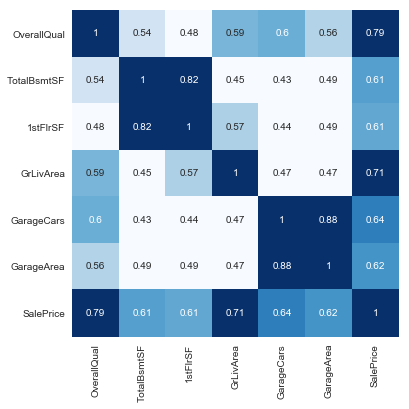

In [15]:
# visualization of top correlated features:
plt.figure(figsize= (6,6))
g = sns.heatmap(train_dup[top_corr_features].corr(),
               annot = True, cmap = "Blues",
                cbar = False, vmin = .5,
                vmax = .7, square = True
               )

In [16]:
## Now we use Pairplot top see outliers and relationship between the categorical nd numeric variable

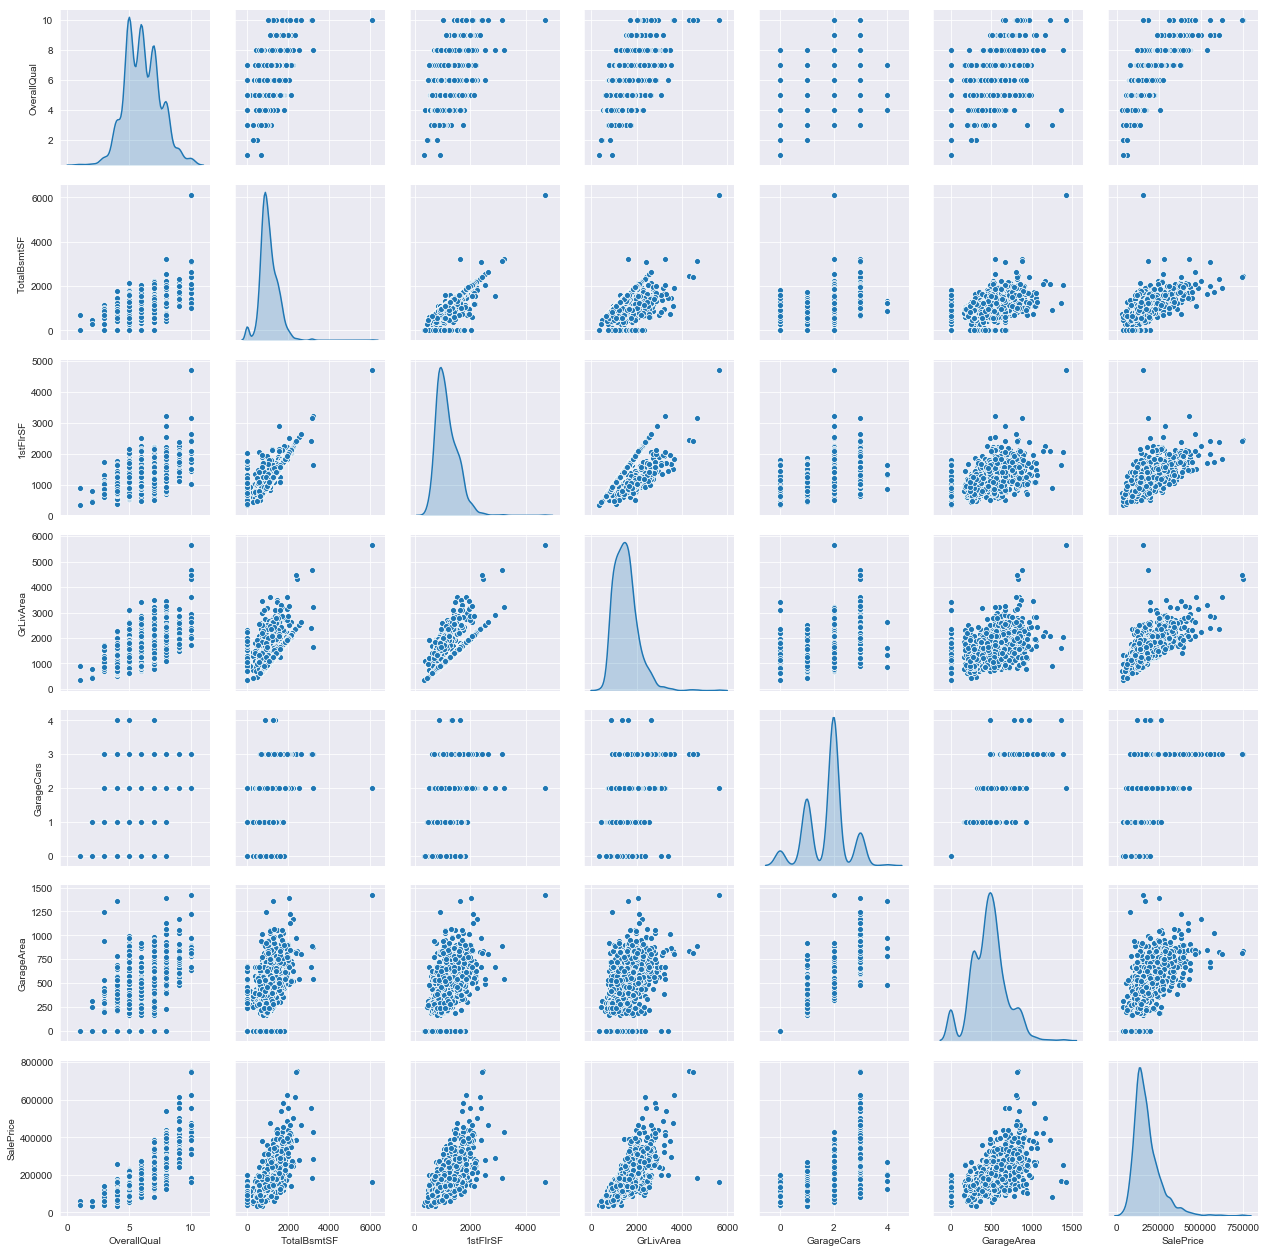

In [17]:
sns.pairplot(train_dup[top_corr_features], diag_kind='kde')

Outliers identified from visualization

* totalBsmtSF > 4000
* 1stFLrSF > 4000
* grlivArea > 4000

In [19]:
train_dup.shape

(1460, 80)

In [23]:
# dropping the outliers
train_dup = train_dup[(train_dup['GrLivArea']< 4500)]
train_dup = train_dup[(train_dup['TotalBsmtSF']< 4000)]
train_dup = train_dup[(train_dup['1stFlrSF'] < 4000)]
train_dup.shape

(1458, 80)

### Handling Skewness of the target (Sales Price)

First, lets look at our target variable
 methods to solve skewness:
 * apply np.log1p to return natural logarithm another 
 
 Using log istandard way to handle the skewness of the data

The sales price are skewed quite a bit


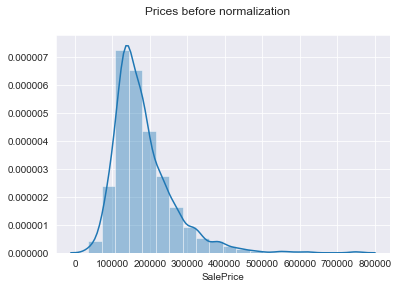

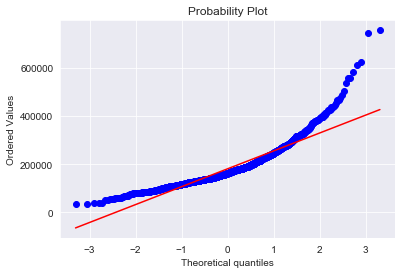

In [24]:
from scipy.stats import probplot

print("The sales price are skewed quite a bit")
sns.distplot(train_dup.SalePrice, bins = 20)
plt.suptitle("Prices before normalization")
plt.show()

probplot(train_dup.SalePrice, plot=plt)
plt.show()

We can clearly see that the distribution is skewed, now we apply log1p function to normalize, lets see how the distribution looks after applying the log1p function

In [25]:
train_dup['SalePrice'] = np.log1p(train_dup['SalePrice'])

# also lets define target as y
y = train_dup['SalePrice'].values

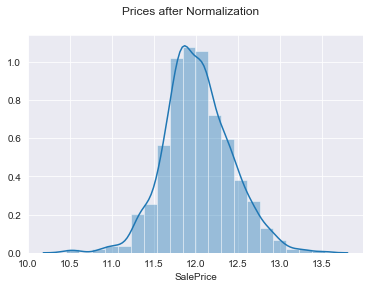

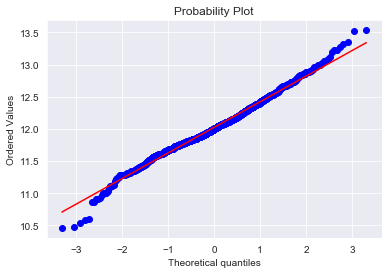

In [26]:
# visualization of distribution
sns.distplot(train_dup.SalePrice, bins = 20)
plt.suptitle("Prices after Normalization")
plt.show()

probplot(train_dup.SalePrice, plot=plt)
plt.show()

Thats, really great, we have successfully fixed the problem of skewness now we combine train and test datasets to obtain the consistency as discussed before

In [27]:
# Combining datasets
combined_df = pd.concat([train_dup.drop(['SalePrice'], axis = 1), test], axis = 0)

In [30]:
# checking the length of the size of each sets
print("train_ data set:", len(train_dup))
print("test_ data set:", len(test))
print("Combined_ data set:", len(combined_df))

train_ data set: 1458
test_ data set: 1459
Combined_ data set: 2917


### Data Cleaning

Handling the null values:
 now lets see the count of total null value's in each column along with the percentage of null such that we can decide on what can be done with those null values.


In [34]:
def null_view(df):
    null_view = df[[col  for col in df.columns if df[col].isna().sum()>0]].isna().sum().sort_values(ascending = False)
    null_view = pd.DataFrame(null_view, columns=['n_nulls'])
    null_view['p_null'] = null_view['n_nulls'].apply(lambda x: str(round((x/len(df))*100,2))+ '%')
    print(null_view.head(10))
    
null_view(train_dup)
print('')
null_view(test)
print('')
null_view(combined_df)

              n_nulls  p_null
PoolQC           1452  99.59%
MiscFeature      1404   96.3%
Alley            1367  93.76%
Fence            1177  80.73%
FireplaceQu       690  47.33%
LotFrontage       259  17.76%
GarageYrBlt        81   5.56%
GarageType         81   5.56%
GarageFinish       81   5.56%
GarageQual         81   5.56%

              n_nulls  p_null
PoolQC           1456  99.79%
MiscFeature      1408   96.5%
Alley            1352  92.67%
Fence            1169  80.12%
FireplaceQu       730  50.03%
LotFrontage       227  15.56%
GarageYrBlt        78   5.35%
GarageCond         78   5.35%
GarageQual         78   5.35%
GarageFinish       78   5.35%

              n_nulls  p_null
PoolQC           2908  99.69%
MiscFeature      2812   96.4%
Alley            2719  93.21%
Fence            2346  80.43%
FireplaceQu      1420  48.68%
LotFrontage       486  16.66%
GarageFinish      159   5.45%
GarageYrBlt       159   5.45%
GarageQual        159   5.45%
GarageCond        159   5.45%


In [75]:
df_final = combined_df[:]
# interpretations of null values
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null int64
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 non

####  visualization of the above null values in heatmap
we also see the null values using the heatmap of seaborn library


In [76]:
def visualize_Nulls(df):
    sns.heatmap(df.isnull(), cbar = False, yticklabels=False)

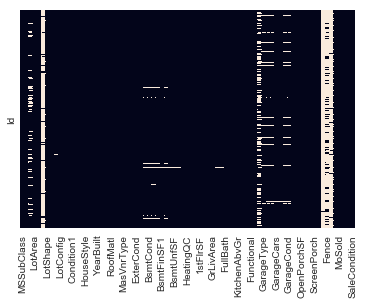

In [77]:
visualize_Nulls(df_final)

Now as these four columns "Alley", "PoolQC", "Fence", "MiscFeature" have too many null values, its appropriate to drop them 

In [78]:
null_values = [col for col in df_final.columns if df_final[col].isnull().sum() >= df_final.shape[0]/2]
print(null_values)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


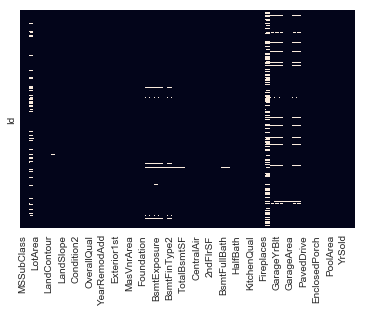

In [79]:
# drop these values
df_final = df_final.drop(columns= null_values, axis=1)
visualize_Nulls(df_final)

Now, the data is free from those null values but still there are some null values, so we fix those null values by filling them up with suitable values based on their object type

In [80]:
# define the qualitative and quantative columns:
qual_cols = [col for col in df_final.columns if df_final[col].dtype in ['object','str'] ]
quan_cols = [col for col in df_final.columns if df_final[col].dtype not in ['object', 'str']]
cat_cols = [col for col in df_final.columns if df_final[col].dtype in ['object']]

In [81]:
# checking no of columns for quntitavie and qualitative terms
print("Quantative cols:",len(qual_cols))
print("Qualitative cols:",len(quan_cols))
print("Only cat_cols:", len(cat_cols))

Quantative cols: 39
Qualitative cols: 36
Only cat_cols: 39


In [82]:
# function to fill missing value for categories
def handle_categorical(multcolumns):
    copy = pd.DataFrame()
    i = 0
    for field in multcolumns:
        temp = df_final[field].fillna(df_final[field].mode()[0])
        df_final.drop([field], axis=1, inplace=True)
        
        if i == 0:
            copy = temp.copy()
            
        else:
            copy = pd.concat([copy, temp], axis=1)
            
        i += 1
        
    copy = pd.concat([df_final, copy], axis= 1)
    return copy

In [83]:
# function to fill numerical values
def handle_numValues(multcolumns):
    copy = pd.DataFrame()
    i = 0
    for field in multcolumns:
        temp = df_final[field].fillna(df_final[field].mean())
        df_final.drop([field], axis=1, inplace=True)
        
        if i == 0:
            copy = temp.copy()
            
        else:
            copy = pd.concat([copy, temp], axis=1)
            
        i = i+1
        
    copy = pd.concat([df_final, copy], axis=1)
    return copy

In [84]:
df_final.shape

(2917, 75)

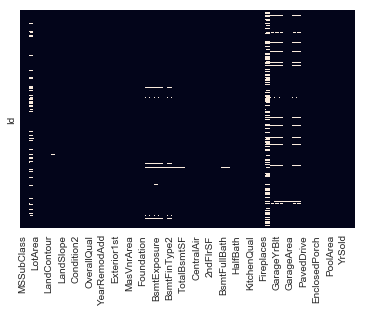

In [85]:
visualize_Nulls(df_final)

In [86]:
df_final = handle_nullValues(quan_cols)

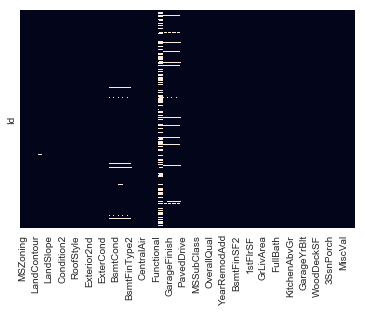

In [87]:
visualize_Nulls(df_final)

In [88]:
df_final = handle_categorical(qual_cols)

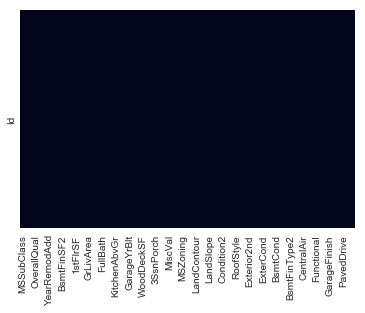

In [89]:
visualize_Nulls(df_final)

Now, the data seems clean free of any null values

### Skew for rest of the dataset

we will also fix the skewness for other quantitaive columns with skre > 0.7

In [91]:
def show_dist(df, fields, title):
    for field in fields:
        sns.distplot(df[field], bins = 20)
        plt.suptitle(title)
        plt.show()

In [92]:
# skew is normally 0.5 but we have choosen 0.7 in this case

def skew_(df):
    #columns which are skew candidates
    cols = [col for col in df.columns if df[col].dtype in ['int64','float']]
    skew_df = [col for col in df[cols].columns if abs(df[col].skew())>0.7]
    
    #function to correct skew:
    def skewfix(data, data2):
        for i in data2:
            data[i] = np.log1p(data[i])
            return data
        
    return skewfix(df, skew_df)

In [104]:
#show_dist(df_final, quan_cols, "Before Normalization")
df_final.shape

(2917, 75)

In [103]:
# now we apply the above function to normalize these quantitaive fields
df_final = skew_(df_final)

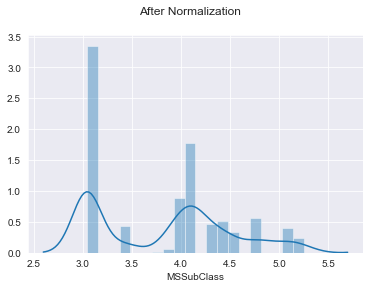

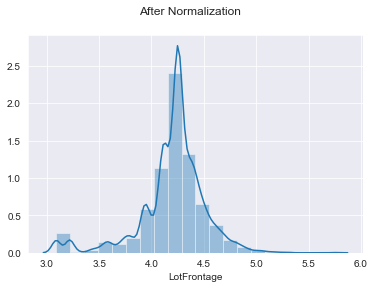

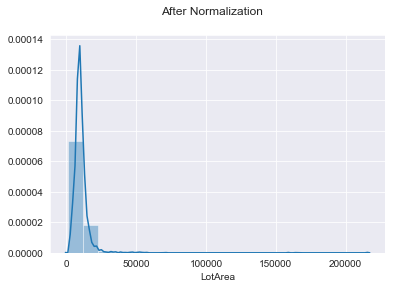

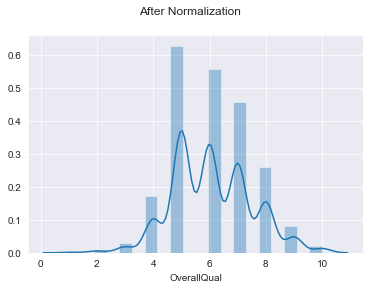

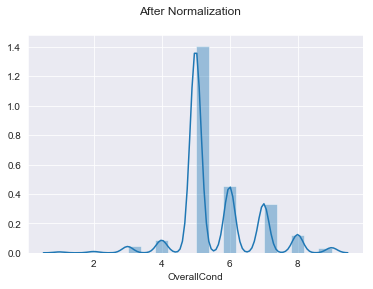

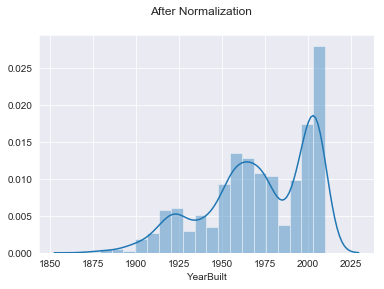

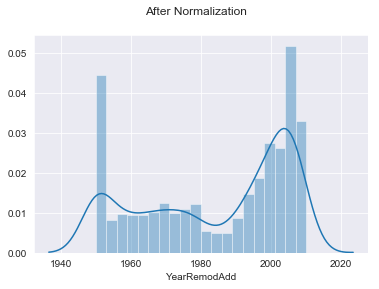

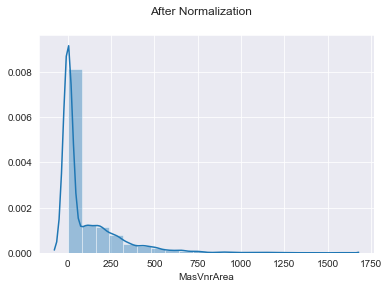

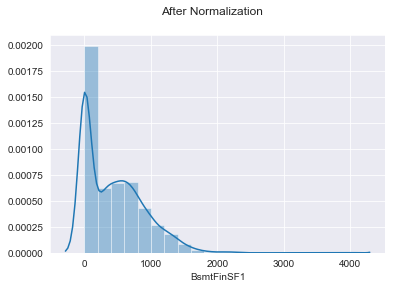

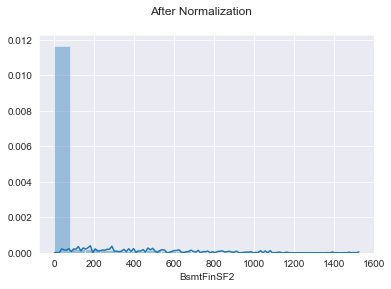

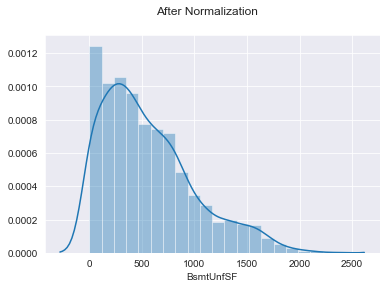

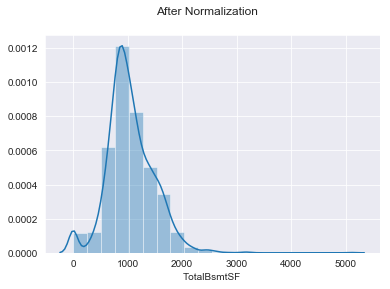

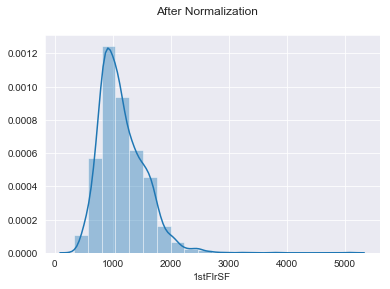

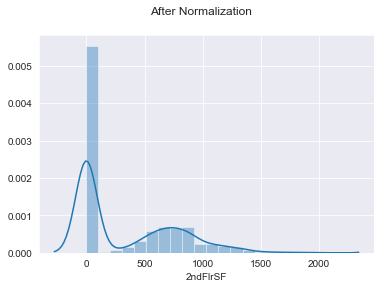

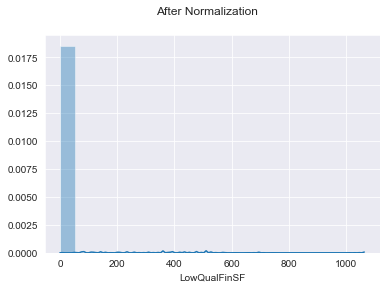

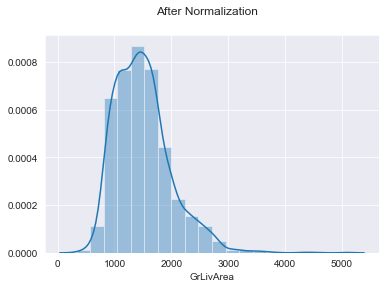

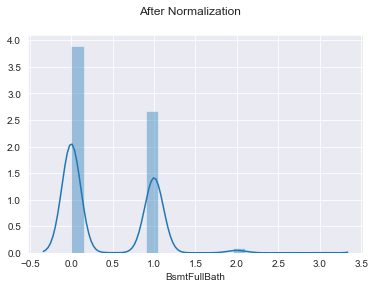

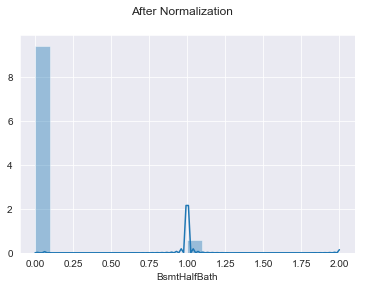

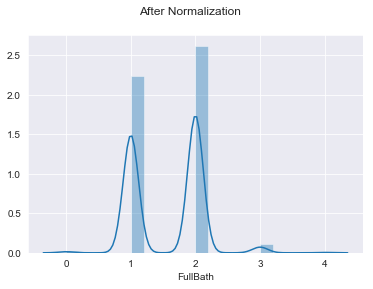

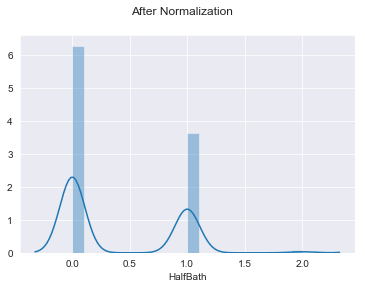

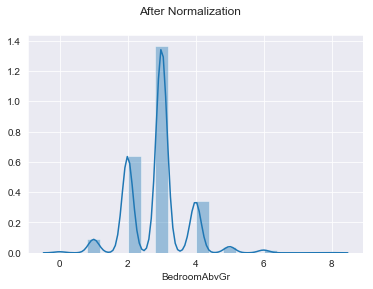

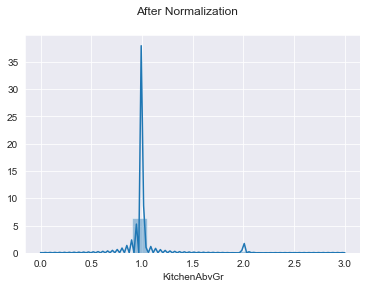

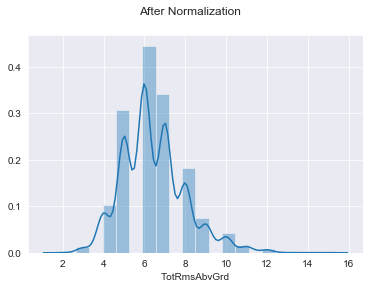

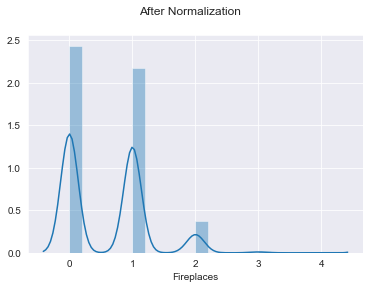

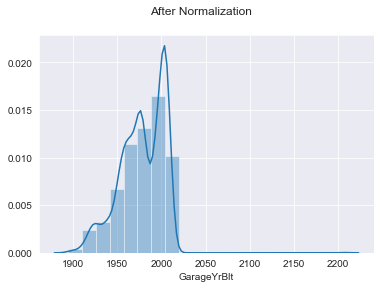

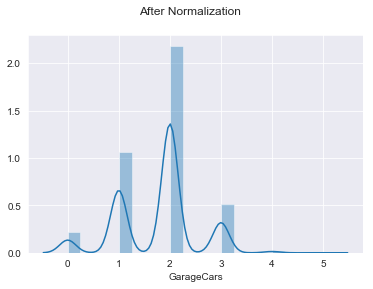

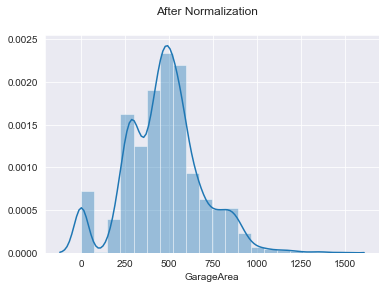

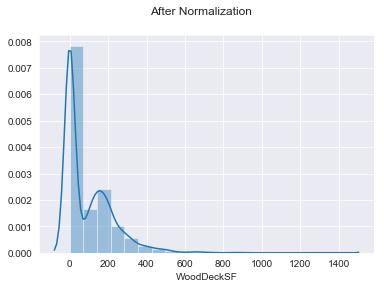

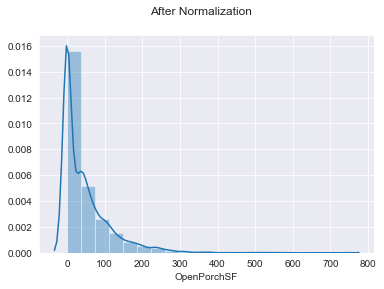

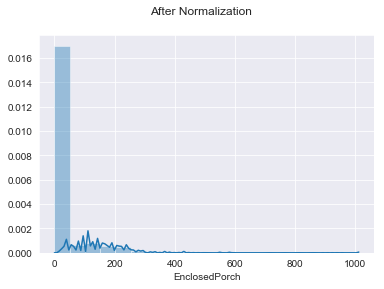

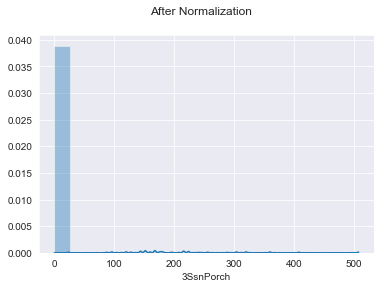

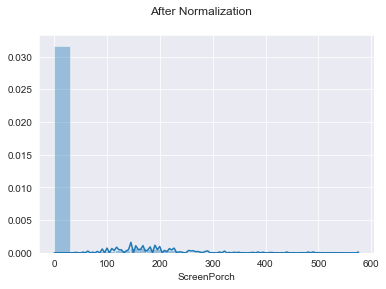

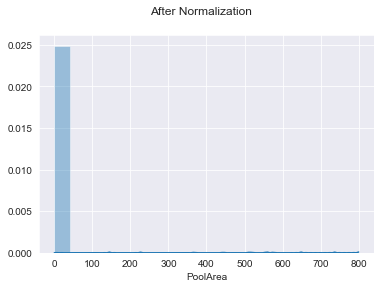

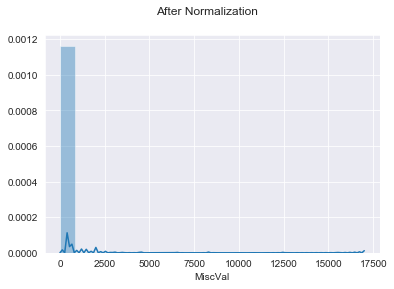

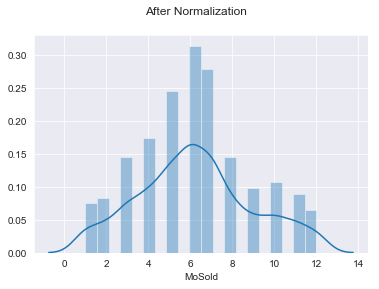

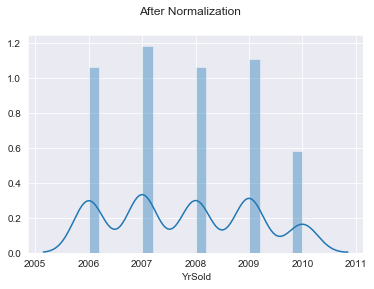

In [99]:
#now lets see the distribution once again
show_dist(df_final, quan_cols, "After Normalization")

## Feature Engineering

Performing feature extraction by combining or altering several elements to a new variable

In [124]:
df = df_final[:]

In [125]:
def feat_eng(df):
    df['totalSF'] = df['TotalBsmtSF'] \
                   + df['1stFlrSF'] \
                   + df['2ndFlrSF'] \
                   + df['GrLivArea']
    
    df['YrBltAndRemod']= df['YearBuilt'] + df['YearRemodAdd']
    
    df['Porch_SF'] = (df['OpenPorchSF'] \
                      + df['3SsnPorch'] \
                      + df['EnclosedPorch'] \
                      + df['ScreenPorch'] \
                      + df['WoodDeckSF'])
    
    df['Total_Bathrooms'] = (df['FullBath'] \
                             + (0.5 * df['HalfBath']) \
                             + df['BsmtFullBath'] \
                             + (0.5 * df['BsmtHalfBath']))
    
    df['hpool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['h2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df
    

In [126]:
df = feat_eng(df)

### Data Preparation

Inoreder to use qualitative variables we are encoding and scaling the variables

In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

In [128]:
# encoding variable with categorical data:
encoder = LabelEncoder()
sc = StandardScaler()

In [129]:
def encode(df):
    cat_df = [col for col in df.columns if df[col].dtype in ['object']]
    for col in cat_df:
            df[col] = encoder.fit_transform(df[col])
            
    df_ = sc.fit_transform(df)
    df = pd.DataFrame(data = df_, columns=df.columns)
    return df

In [130]:
df.shape

(2917, 84)

In [131]:
df = encode(df)
df.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,totalSF,YrBltAndRemod,Porch_SF,Total_Bathrooms,hpool,h2ndfloor,hgarage,hbsmt,hfireplace
0,0.419587,-0.013685,-0.216437,0.649580,-0.507503,1.047231,0.897702,0.530259,0.601276,-0.293239,...,0.205764,0.190209,1.094096,-0.761881,1.589910,-0.064271,1.155625,0.238504,0.165754,-1.026755
1,-1.120241,0.590637,-0.069108,-0.061424,2.187374,0.155606,-0.394865,-0.572262,1.213847,-0.293239,...,0.205764,-0.206622,-0.076667,0.721802,0.350554,-0.064271,-0.865333,0.238504,0.165754,0.973942
2,0.419587,0.119488,0.142276,0.649580,-0.507503,0.981185,0.849829,0.339005,0.105814,-0.293239,...,0.205764,0.365139,1.029054,-0.880826,1.589910,-0.064271,1.155625,0.238504,0.165754,0.973942
3,0.638798,-0.252532,-0.075514,0.649580,-0.507503,-1.858805,-0.682102,-0.572262,-0.502253,-0.293239,...,-3.504979,0.120561,-1.529280,0.778145,-0.269123,-0.064271,1.155625,0.238504,0.165754,0.973942
4,0.419587,0.729539,0.527891,1.360583,-0.507503,0.948161,0.754083,1.396525,0.486419,-0.293239,...,0.205764,1.214680,0.964011,0.584076,1.589910,-0.064271,1.155625,0.238504,0.165754,0.973942


### Model Fit

In [132]:
df.shape

(2917, 84)

In [133]:
train_dup.shape

(1458, 80)

In [134]:
train_data = df.iloc[:train_dup.shape[0],:]
test_data = df.iloc[train_dup.shape[0]:,:]

In [135]:
from sklearn.model_selection import train_test_split
x = train_data.copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

### Hyper Parameter tuing with gridsearch CV

Five models have been tested
1. Light GBM
2. XGBoost
3. Gradient Boost
4. K-Nearest Neighbors
5. Random Forest

In [136]:
import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Light GBM

In [137]:
from lightgbm import LGBMRegressor
print('#############################\n{}\tLightGBM'.format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'objective': ['regression'],
    'num_leaves':[5],
    'learning_rate':[0.05],
    'n_estimators':[720],
    'max_bin':[55],
    'max_depth':[2,3],
    'bagging_fraction':[.5,.8],
    'bagging_freq':[5],
    'bagging_seed':[9],
    'feature_fraction':[0.2319],   
}

light = LGBMRegressor()
clf = GridSearchCV(light, parameters, verbose=0, iid = False)
clf.fit(x_train, y_train)

#############################
17:39	LightGBM


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_l...
                                     subsample_freq=0),
             iid=False, n_jobs=None,
             param_grid={'bagging_fraction': [0.5, 0.8], 'bagging_freq': [5],
                         'bagging_seed': [9], 'feature_fraction': [0.2319],
                         'learning_rate': [0.05], 'max_bin': [55],
                         'max_depth': [2, 3

In [138]:
lightgbm = LGBMRegressor(**clf.best_params_)

print('\nRegressor: \n', lightgbm, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))


Regressor: 
 LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, importance_type='split',
              learning_rate=0.05, max_bin=55, max_depth=2, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=720,
              n_jobs=-1, num_leaves=5, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0) 

17:40	Done!
####################################################


## XGBOOST

In [140]:
from xgboost import XGBRegressor
print('####################################################\n{}\tXGBoost'
      .format(datetime.datetime.now().strftime('%H:%M')))

params = {
    'colsample_bytree':[0.4],
    'gamma':[0.0],
    'learning_rate':[0.01],
    'max_depth':[3],
    'min_child_weight':[2],
    'n_estimators':[3460],
    'seed':[36],
    'subsample':[0.2],
    'objective':['reg:squarederror'],
    'reg_alpha':[0.00006],
    'cale_pos_weight':[1],
    'verbosity':[0]
}

gbm = XGBRegressor()
clf = GridSearchCV(gbm, params, verbose = 0, iid = False)
clf.fit(x_train, y_train)
XGBoost = XGBRegressor(**clf.best_params_)
print('\nRegressor: \n', XGBoost, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

####################################################
17:48	XGBoost

Regressor: 
 XGBRegressor(base_score=0.5, booster='gbtree', cale_pos_weight=1,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             gamma=0.0, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=3, min_child_weight=2, missing=None,
             n_estimators=3460, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=36, silent=None,
             subsample=0.2, verbosity=0) 

17:48	Done!
####################################################


## Gradient Boosting Regressor

In [142]:
from sklearn.ensemble import GradientBoostingRegressor
print('##############################################\n{}\tGradient Boost'.format(datetime.datetime.now().strftime('%H:%M')))

parameters = {
    'n_estimators': [8000],
    'learning_rate':[0.01],
    'max_depth':[2],
    'max_features':['sqrt'],
    'min_samples_leaf':[10],
    'min_samples_split':[5],
    'loss':['huber'],
    'random_state':[42]
}

gbr = GradientBoostingRegressor()
clf = GridSearchCV(gbr, parameters, verbose=0, iid = False)
clf.fit(x_train, y_train)
gbr= GradientBoostingRegressor(**clf.best_params_)

print('\nRegressor: \n', gbr, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M')))

##############################################
17:54	Gradient Boost

Regressor: 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=8000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

17:54	Done!
####################################################


### KNeighbours

In [144]:
from sklearn.neighbors import KNeighborsRegressor
print('####################################################\n{}\tK-nearest neighbor'
      .format(datetime.datetime.now().strftime('%H:%M:%S')))
parameters = {
    'algorithm':['auto'],
    'leaf_size':[2,3,5,7],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan'],
    'n_neighbors':[5,10]
}

knn = KNeighborsRegressor()
clf= GridSearchCV(knn, parameters, verbose=0, iid= False)
clf.fit(x_train, y_train)
knn = KNeighborsRegressor(**clf.best_params_)
print('\nRegressor: \n', knn, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M:%S')))

####################################################
18:00:38	K-nearest neighbor

Regressor: 
 KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance') 

18:00:51	Done!
####################################################


### RandomForest Regressor

In [145]:
from sklearn.ensemble import RandomForestRegressor
print('####################################################\n{}\tRandom forest'
      .format(datetime.datetime.now().strftime('%H:%M:%S')))

parameters = {
    'bootstrap':['auto'],
    'max_features':['auto'],
    'min_samples_leaf':[2],
    'min_samples_split':[4],
    'n_estimators':[1500],
    'n_jobs':[-1],
    'oob_score':[True]
}

r_forest = RandomForestRegressor()
clf = GridSearchCV(r_forest, parameters, verbose=0, iid = False)
clf.fit(x_train, y_train)
random_forest = RandomForestRegressor(**clf.best_params_)


print('\nRegressor: \n', random_forest, '\n')
print('{}\tDone!\n####################################################'
      .format(datetime.datetime.now().strftime('%H:%M:%S')))


####################################################
18:05:30	Random forest

Regressor: 
 RandomForestRegressor(bootstrap='auto', criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                      warm_start=False) 

18:06:18	Done!
####################################################


### Pipelines for following models has been defined

* Ridge Regression
* Lasso Regression
* Elasticnet SVR

In [147]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# importing library for making pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

alphas_ridge = [
    14.5,14.6,14.7,14.8,14.9,15, 
    15.1, 15.2, 15.3, 15.4, 15.5, 15.6
]

ridge = make_pipeline(RobustScaler(),
                     RidgeCV(
                         alphas = alphas_ridge,
                         cv = kfolds
                     ))

print('############################################################\nRidge: \n', 
      ridge, 
      '\n############################################################\n')

############################################################
Ridge: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5,
       15.6]),
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False) 
############################################################



In [148]:
from sklearn.linear_model import LassoCV

alphas_lasso = [
    5e-05, 0.0001, 0.0002, 0.0003, 
    0.0004, 0.0005, 0.0006, 0.0007
]

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(
        alphas = alphas_lasso,
        max_iter = 1e7,
        random_state = 42,
        cv = kfolds
    )
)

print('############################################################\nLasso: \n', 
      lasso,
      '\n############################################################\n')



############################################################
Lasso: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007],
                         copy_X=True,
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         eps=0.001, fit_intercept=True, max_iter=10000000.0,
                         n_alphas=100, n_jobs=None, normalize=False,
                         positive=False, precompute='auto', random_state=42,
                         selection='cyclic', tol=0.0001, verbose=False))],
         verbose=False) 
############################################################



In [149]:
from sklearn.linear_model import ElasticNetCV

alphas_ela = [
    0.0001, 0.0002, 0.0003, 
    0.0004, 0.0005, 0.0006, 0.0007
]

e_l1ratio = [0.8,0.85,0.9,0.95,0.99,1]

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(
        max_iter= 1e7,
        alphas = alphas_ela,
        cv = kfolds,
        l1_ratio = e_l1ratio
    )
)

print('############################################################\nElastic: \n',
      elasticnet, 
      '\n############################################################\n')

############################################################
Elastic: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                      0.0006, 0.0007],
                              copy_X=True,
                              cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              eps=0.001, fit_intercept=True,
                              l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1],
                              max_iter=10000000.0, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=Fal

In [150]:
## suppor vector machines
from sklearn.svm import SVR

parameters = {
    'C':[120],
    'gamma':[0.0003]
}

svr_ = SVR()
clf = GridSearchCV(svr_, parameters, verbose=0, iid = False)
clf.fit(x_train, y_train)

svr = make_pipeline(
    RobustScaler(),
    SVR(**clf.best_params_)
)

print('############################################################\nSVR: \n', 
      svr, 
      '\n############################################################\n')

############################################################
SVR: 
 Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=120, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.0003, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False) 
############################################################



## Stacking the models

In [151]:
# importing the library for stacking
from mlxtend.regressor import StackingCVRegressor

In [153]:
#SVR, KNN and Random Forest has been removed
print('Stacking: \t stack_gen')

stack_gen = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=XGBoost,
    use_features_in_secondary=True
)

print('Done! \n')

print('Stacking: \t stack_gen2')
stack_gen2 = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=lightgbm,
    use_features_in_secondary=True
)

print('Done \n')

print('Stacking: \t stack_gen3')
stack_gen3 = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor=ridge,
    use_features_in_secondary=True
)

print('Done \n')

print('Stacking: \t stack_gen4')
stack_gen4 = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, lightgbm, XGBoost, gbr),
    meta_regressor = lasso,
    use_features_in_secondary= True
)
print('Done! \n')

Stacking: 	 stack_gen
Done! 

Stacking: 	 stack_gen2
Done 

Stacking: 	 stack_gen3
Done 

Stacking: 	 stack_gen4
Done! 



### Fitting the models

In [156]:
models = {
    'svr': svr_,
    'Ridge': ridge,
    'lightgbm':lightgbm,
    'XGBoost':XGBoost,
    'GradientBoost':gbr,
    'Lasso':lasso,
    'ElasticNet':elasticnet,
    'Random Forest':r_forest,
    'KNN':knn
}

# importing metics for calculation of error
from sklearn import metrics

def calc(model):
    return int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(model.predict(x_test)))))

liste = []

for key, values in models.items():
    print('Fitting: \t{}'.format(key))
    values.fit(x_train, y_train)
    test_val = calc(values)
    print('Done! Error: \t{}\n'.format(test_val))
    df = pd.DataFrame(
        data = [test_val],
        index = [key],
        columns=['error']
    )
    liste.append(df)
          

Fitting: 	svr
Done! Error: 	39697

Fitting: 	Ridge
Done! Error: 	21072

Fitting: 	lightgbm
Done! Error: 	24638

Fitting: 	XGBoost
Done! Error: 	22573

Fitting: 	GradientBoost
Done! Error: 	20125

Fitting: 	Lasso
Done! Error: 	21149

Fitting: 	ElasticNet
Done! Error: 	21149

Fitting: 	Random Forest
Done! Error: 	23825

Fitting: 	KNN
Done! Error: 	31560



In [160]:
reList = pd.concat(liste, axis=0)
reList

,error
svr,39697
Ridge,21072
lightgbm,24638
XGBoost,22573
GradientBoost,20125
Lasso,21149
ElasticNet,21149
Random Forest,23825
KNN,31560


### Stacking

In [169]:
print('Stack_gen: \t fitting....')
stack_gen_model = stack_gen.fit(np.array(x_test), np.array(y_test))
sg_error = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test),np.expm1(stack_gen_model.predict(np.array(x_test))))))
print('stack_gen: \t done!!')
print('error: \t\t', sg_error, '\n')

print('stack_gen2: \t fitting.......')
stack_gen_model2 = stack_gen2.fit(np.array(x_test), np.array(y_test))
sg_error2 = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test),np.expm1(stack_gen_model2.predict(np.array(x_test))))))
print('stack_gen2: \t done!!')
print('error: \t\t', sg_error2, '\n')

print('stack_gen3: \t fitting.......')
stack_gen_model3 = stack_gen3.fit(np.array(x_test), np.array(y_test))
sg_error3 = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test),np.expm1(stack_gen_model3.predict(np.array(x_test))))))
print('stack_gen3: \t done!!')
print('error: \t\t', sg_error3, '\n')

print('stack_gen4: \t fitting.......')
stack_gen_model4 = stack_gen4.fit(np.array(x_test), np.array(y_test))
sg_error4 = int(np.sqrt(metrics.mean_squared_error(np.expm1(y_test),np.expm1(stack_gen_model4.predict(np.array(x_test))))))
print('stack_gen4: \t done!!')
print('error: \t\t', sg_error4, '\n')

sg = pd.DataFrame(index = ['stack_gen'], data = sg_error, columns = ['error'])
sg2 = pd.DataFrame(index = ['stack_gen2'], data = sg_error2, columns = ['error'])
sg3 = pd.DataFrame(index = ['stack_gen3'], data = sg_error3, columns = ['error'])
sg4 = pd.DataFrame(index = ['stack_gen4'], data = sg_error4, columns = ['error'])


Stack_gen: 	 fitting....
stack_gen: 	 done!!
error: 		 7034 

stack_gen2: 	 fitting.......
stack_gen2: 	 done!!
error: 		 17275 

stack_gen3: 	 fitting.......
stack_gen3: 	 done!!
error: 		 13538 

stack_gen4: 	 fitting.......
stack_gen4: 	 done!!
error: 		 15576 



In [170]:
reList = reList.append(sg)
reList = reList.append(sg2)
reList = reList.append(sg3)
reList = reList.append(sg4)

In [171]:
reList

,error
svr,39697
Ridge,21072
lightgbm,24638
XGBoost,22573
GradientBoost,20125
Lasso,21149
ElasticNet,21149
Random Forest,23825
KNN,31560
stack_gen,7608


# Ensambling
Ensambling for a blended predition model


In [180]:
# def blend(data):
#     return (
#         (0.01 * svr_.predict(data)) +
#         (0.08 * ridge.predict(data)) +
#         (0.11 * lightgbm.predict(data)) +
#         (0.13 * XGBoost.predict(data)) +
#         (0.10 * gbr.predict(data)) +
#         (0.15 * stack_gen_model.predict(np.array(data))) +
#         (0.16 * stack_gen_model2.predict(np.array(data))) +
#         (0.16 * stack_gen_model3.predict(np.array(data))) +
#         (0.06 * lasso.predict(data)) +
#         (0.03 * knn.predict(data)) + 
#         (0.02 * r_forest.predict(data)) +
#         (0.05 * elasticnet.predict(data)) 
#         )

# blended_predictions = blend(test)

### All models with error visualization

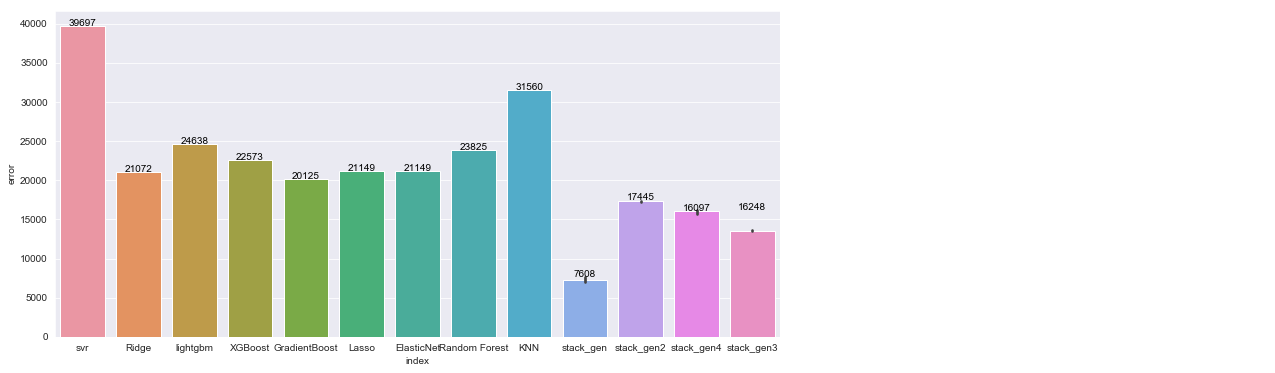

In [183]:
reList2 = reList.reset_index()
plt.figure(figsize=(13,6))
ax1 = sns.barplot(
    x = reList2['index'],
    y = reList2.error
)

for i, rows in reList2.iterrows():
    ax1.annotate(
        round(rows['error'],1),
        xy = (i, rows['error']),
        xycoords = 'data',
        ha = 'center',
        color = 'black'
    )